In [1]:

import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

numpy: 1.21.5


In [2]:
torch.__version__

'1.10.0'

In [3]:
import os
os.chdir('../')

In [4]:
from benji_prox_dataloader import *
root_dir = 'D:/prox_data/PROXD_attempt2/PROXD'
in_frames = 10
pred_frames = 5
pd = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, verbose=False)

dataloader = DataLoader(pd, batch_size=4,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

In [5]:
class MockupModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: np.ndarray, seq_len):
        super().__init__()

        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.input_size = input_size
        self.output_size=output_size

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(input_size=np.product(input_size), hidden_size=hidden_size, num_layers=num_layers, batch_first=True),
            'linear': nn.Linear(in_features=hidden_size*seq_len, out_features=np.product(output_size))})  # is this correct?l

    def forward(self, input):
        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        logging.debug(f'input: {input.shape}')
        input = input.reshape(-1, self.seq_len, self.input_size)
        logging.debug(f'input trans: {input.shape}')

       
        # Data is fed to the LSTM
        out, (h_n, c_n) = self.model['lstm'](input)
        logging.debug(f'h_n: {h_n.shape}; c_n: {c_n.shape}')
        logging.debug(f'lstm out: {out.shape}')


        # in_bs = input.shape[1]
        out = out.reshape(-1, self.seq_len*self.hidden_size)
        logging.debug(f'linear in: {out.shape}')
        out = self.model['linear'](out)
        logging.debug(f'linear out: {out.shape}')
        return out.reshape((-1,) + self.output_size)


In [70]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape

torch.Size([5, 3, 20])

In [73]:
hn.shape
hn[-1]
output[-1]

torch.Size([2, 3, 20])

tensor([[ 0.0298,  0.0374, -0.1854,  0.0906,  0.1068,  0.0468, -0.0153,  0.1666,
         -0.1042, -0.1513, -0.0256,  0.0872, -0.0668, -0.1188,  0.0823,  0.0799,
         -0.0492, -0.1464,  0.0095, -0.0931],
        [ 0.0502,  0.0263, -0.1283,  0.0511,  0.0896,  0.0584, -0.0352,  0.1302,
         -0.1181, -0.1617, -0.0018,  0.0657, -0.0620, -0.0628,  0.0569,  0.0662,
         -0.0397, -0.0959,  0.0386, -0.1260],
        [ 0.0573,  0.0936, -0.1105,  0.0531,  0.0617,  0.0475,  0.0313,  0.2000,
         -0.0554, -0.1514, -0.0164,  0.0675, -0.0273, -0.1004,  0.0694,  0.0559,
          0.0004, -0.1030, -0.0433, -0.0180]], grad_fn=<SelectBackward0>)

tensor([[ 0.0298,  0.0374, -0.1854,  0.0906,  0.1068,  0.0468, -0.0153,  0.1666,
         -0.1042, -0.1513, -0.0256,  0.0872, -0.0668, -0.1188,  0.0823,  0.0799,
         -0.0492, -0.1464,  0.0095, -0.0931],
        [ 0.0502,  0.0263, -0.1283,  0.0511,  0.0896,  0.0584, -0.0352,  0.1302,
         -0.1181, -0.1617, -0.0018,  0.0657, -0.0620, -0.0628,  0.0569,  0.0662,
         -0.0397, -0.0959,  0.0386, -0.1260],
        [ 0.0573,  0.0936, -0.1105,  0.0531,  0.0617,  0.0475,  0.0313,  0.2000,
         -0.0554, -0.1514, -0.0164,  0.0675, -0.0273, -0.1004,  0.0694,  0.0559,
          0.0004, -0.1030, -0.0433, -0.0180]], grad_fn=<SelectBackward0>)

1469it [13:12,  1.85it/s]


[0.2113913595676422, 0.12679673731327057, 0.1892542839050293, 0.08245917409658432]


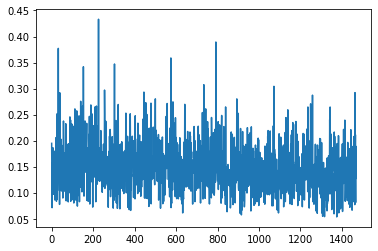

In [39]:
criterion = nn.MSELoss()
learning_rate=0.00001
losses = []
losses_rep = []

rnn = MockupModel(input_size=21*3, hidden_size=50, num_layers=2, output_size=(pred_frames, 21, 3), seq_len=in_frames)

n_iter = 1
bs = 30
i = 0

for i, (indices, in_skels, pred_skels) in tqdm.tqdm(enumerate(dataloader)):
    output = rnn(in_skels)
    loss = criterion(output, pred_skels)
    loss.backward()
    #repeat_pred = 

    rep_pred = in_skels[:, -1, :, :]
    rep_pred = rep_pred.tile(pred_frames, 1, 1, 1).transpose(0, 1)
    loss_rep = criterion(rep_pred, pred_skels)
    losses_rep.append(loss_rep)

    for p in rnn.parameters():
        _ = p.data.add_(p.grad.data, alpha=-learning_rate)
    losses.append(loss.item())
    # print(i, loss)


plt.plot(losses)
print(losses[-4:])

In [74]:
in_skels.shape

torch.Size([4, 10, 21, 3])

In [ ]:
losses_rep[-5:]

AttributeError: 'PoseGRU_inputFC' object has no attribute 'hidden'

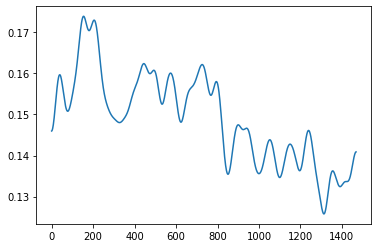

In [48]:
plt.plot(gaussian_filter(losses, sigma=20))

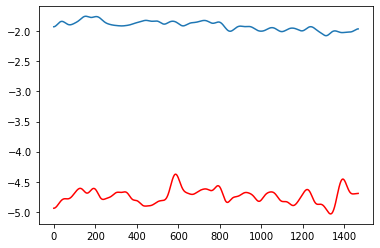

In [51]:
plt.plot(np.log(gaussian_filter(losses, sigma=20)))
plt.plot(np.log(gaussian_filter(losses_rep, sigma=20)), color='red')

In [55]:
torch.min(in_skels)
torch.max(in_skels)
torch.min(pred_skels)
torch.max(pred_skels)

tensor(-1.0774)

tensor(1.2864)

tensor(-1.2333)

tensor(1.4083)

In [60]:
in_skels.shape
in_skels[0, -2, :6]
in_skels[0, -1, :6]
pred_skels[0, 0, :6]

torch.Size([4, 10, 21, 3])

tensor([[ 0.3130,  0.0455, -0.0652],
        [-0.5712,  0.0728,  0.0162],
        [ 0.2158, -0.1059, -0.0386],
        [-0.0323, -0.1706,  0.0347],
        [ 0.4868, -0.0944, -0.0178],
        [-0.0655, -0.0543,  0.0548]])

tensor([[ 0.3192,  0.0343, -0.0728],
        [-0.5910,  0.0802,  0.0175],
        [ 0.2021, -0.1082, -0.0371],
        [ 0.0180, -0.1868,  0.0386],
        [ 0.5461, -0.0984, -0.0153],
        [-0.0772, -0.0501,  0.0588]])

tensor([[ 0.3029,  0.0263, -0.0564],
        [-0.6359,  0.0879,  0.0205],
        [ 0.2078, -0.1110, -0.0400],
        [ 0.0894, -0.1865,  0.0362],
        [ 0.6398, -0.0971, -0.0101],
        [-0.0926, -0.0507,  0.0598]])

In [50]:
xin = df2.MedTemp[:7].array
def predict(xin):
    # hidden = rnn.initHidden()
    out = rnn(torch.tensor(xin).float().reshape(1, -1))
    yout = out.detach().numpy()
    return yout




<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

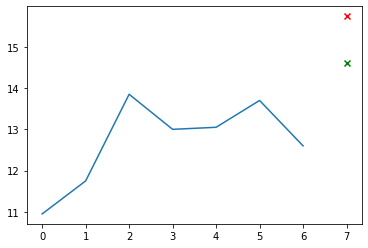

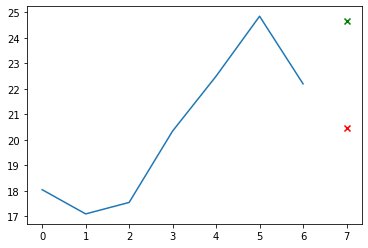

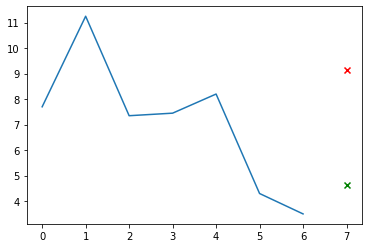

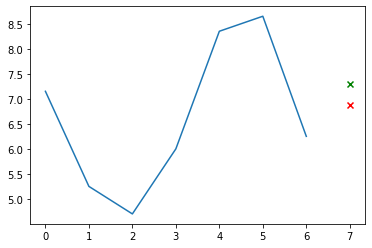

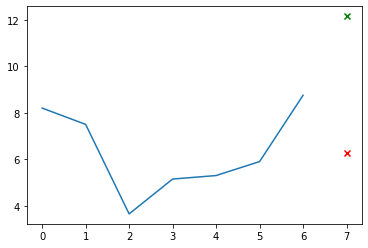

In [51]:
def plot(xin, ypred, ytrue):
    plt.plot(xin)
    plt.scatter(len(xin), ypred, color='r', marker='x')
    plt.scatter(len(xin), ytrue, color='g', marker='x')


for i in range(10, 15):
    xin = X_test[i]
    ypred = predict(xin)
    ytrue = Y_test[i]
    plt.figure()
    plot(xin, ypred, ytrue)


In [50]:
xin

<PandasArray>
[             16.15,              20.45, 18.549999999999997,
               14.4, 11.850000000000001, 11.549999999999999,
 12.149999999999999]
Length: 7, dtype: float64

In [ ]:
3